# Drawing Julia fractals

This notebook draws to screen and makes gifs of Julia fractals. It uses the Python Image Library to make gifs, and uses ipython widgets to allow user interaction with the drawing commands.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import IPython
import ipywidgets as widgets
import math

In [2]:
from typing import *

The heart of this process is the iterated application of a polynomial. The iteration starts at a given point, and if the iterations then stay bounded for all time then that starting point is within the set. Because this is running on a computer we approximate this process by stopping after a certain number of iterations.

In [3]:
def iterated_square_shift(c: complex,z: complex) -> Iterator[complex]:
    """Yield the next iteration of the polynomial"""
    while True:
        yield z
        z = z**2+c

Incidentally we can see the Mandelbrot set as a companion to the Julia set(s), and so our technique works for both.

In [4]:
def julia(parameter: complex) -> Callable[[complex],Iterator[complex]]:
    """Iterator for the Julia fractal"""
    return lambda x: iterated_square_shift(z=x, c=parameter)

def mandelbrot() -> Callable[[complex],Iterator[complex]]:
    """Iterator for the Mandelbrot set"""
    return lambda x: iterated_square_shift(c=x, z=0)

Here's an example where we set the parameter to the Julia fractal to 0.1, and then set the starting point to 1. Calling `julia` this way returns an iterator, and the boundedness of the iterator's values determine whether the starting point is in or out of the Julia set with parameter 0.1.

In [5]:
ex_julia_1 = julia(0.1)(1)
[next(ex_julia_1) for _ in range(10)]

[1,
 1.1,
 1.3100000000000003,
 1.8161000000000007,
 3.398219210000003,
 11.647893799213042,
 135.77342995774563,
 18434.524282490856,
 339831685.62174505,
 1.1548557455251656e+17]

## Drawing still images

Our first drawing attempt uses a scatterplot, so we first create a grid of points, and will then mask which points to render.

In [6]:
def complex_grid(xmin, xmax, ymin, ymax, pixel_density):
    """A grid between the given values"""
    real = np.linspace(xmin, xmax, int((xmax - xmin) * pixel_density))
    imaginary = np.linspace(ymin, ymax, int((ymax - ymin) * pixel_density))
    return real[np.newaxis, :] + imaginary[:, np.newaxis] * 1j

`is_stable` determines whether the iterator's values exceed distance 2 from the origin, only checking up to a set number of iterations before stopping.

In [7]:
def is_stable(iterator, num_iterations):
    z = 0
    for _ in range(num_iterations):
        z = next(iterator)
        if abs(z) > 2:
            return False
    return True

`escape_count` is more nuanced, in that it tells us exactly how quickly an iterator's value exceeds absolute value 2.

In [8]:
def escape_count(iterator, num_iterations):
    z = 0
    for i in range(num_iterations):
        z = next(iterator)
        if abs(z) > 2:
            return i / num_iterations
    return 1

We check whether the point `-1` is within the Julia set with parameter 0, with a limit of 20 iterations before stopping.

In [9]:
is_stable(julia(0)(-1),20)

True

In [10]:
is_stable(julia(0)(-1.0001),20)

False

For our scatterplot drawing method we want to vectorize the function application (apply it in parallel).

In [11]:
def vectorized_is_stable(iterator, iterations, grid):
    return np.vectorize(lambda x: is_stable(iterator(x), iterations))(grid)

In [12]:
def scatter_grid(scope: float, density: int, iterator, iterations=20):
    grid = complex_grid(-scope, scope, -scope, scope, pixel_density=density)
    members = grid[vectorized_is_stable(iterator, iterations, grid)]

    plt.scatter(members.real, members.imag, color="black", marker=",", s=1)
    plt.gca().set_aspect("equal")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Again, all this is doing is plotting a scatterplot. By default every point would be drawn as a black dot, but we use `is_stable` (in vectorized form) to mask out the points that aren't in the fractal we're investigating.

Here's a scatterplot for the Mandelbrot set.

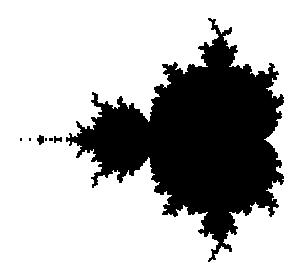

In [13]:
scatter_grid(2,512, mandelbrot())

`plt.imshow` is similar - we pass it a grid of values and it converts these values into pixels.

In [14]:
def imshow(scope: float, density: int, iterator, iterations=20):
    grid = complex_grid(-scope, scope, -scope, scope, pixel_density=density)

    plt.imshow(vectorized_is_stable(iterator, iterations, grid), cmap="binary")
    plt.gca().set_aspect("equal")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

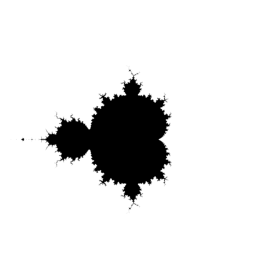

In [15]:
imshow(2,512, mandelbrot())

For more granularity, and the capacity to make gifs, we turn to the Python Image Library (as provided by `pillow`)

In [16]:
def pillow_render(width: int, iterator, iterations=20):
    scale = 4/width
    image = PIL.Image.new(mode="L", size=(width, width))
    for y in range(width):
        for x in range(width):
            c = scale * complex(x - width / 2, width / 2 - y)
            image.putpixel((x, y), int(255*(1-escape_count(iterator(c), iterations))))

    return image

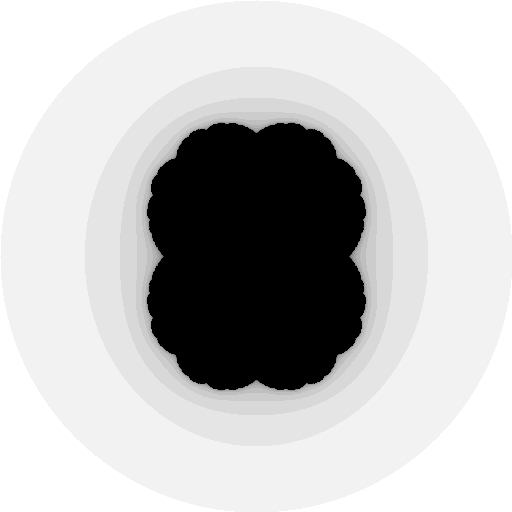

In [17]:
pillow_render(512, julia(0.2))

# Making gifs

To make gifs with PIL we start by constructing a list of image frames then save them all in one go using the `append_images` optional parameter for `PIL.Image.save`.

In [18]:
def make_julia_gif(list_of_julia_param_values):
    """Construct a gif of 512x512 frames, each a different Julia fractal as determined by the list of parameters."""
    frames = [pillow_render(512, julia(param)) for param in list_of_julia_param_values]
    
    frames[0].save("julia.gif", format="GIF", append_images=frames,
                   save_all=True, duration=100, loop=0)

We want to walk along a path of different Julia fractals, and we want this gif to loop, so a cardioid shape seems like a sensible choice.

In [19]:
def cardioid(theta):
    """Cardioid path, theta ranges from 0 to 2pi."""
    r = 0.5 + math.cos(theta)
    return complex(r*math.sin(theta), r*math.cos(theta))

In [20]:
def stepped_cardioid(steps: int):
    """Parameterized curve describing a cardioid (heart) shape in n steps."""
    return [cardioid(theta*2*math.pi/steps) for theta in range(steps)]

Now to make the gif, taking 100 steps to explore the cardioid path in the parameter space of the Julia fractals.

In [21]:
make_julia_gif(stepped_cardioid(100))

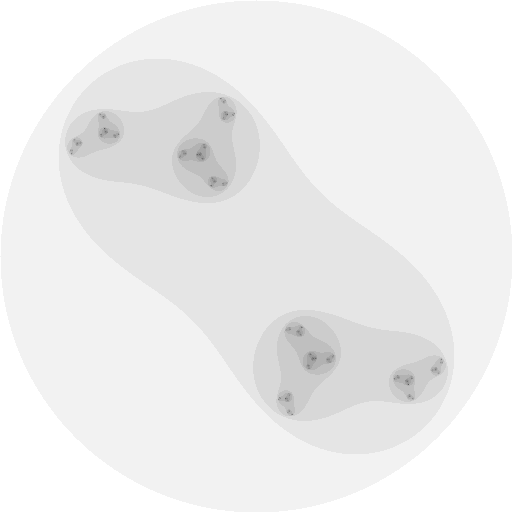

In [33]:
IPython.display.Image(filename='./julia.gif')

## Zooming in

Now we want to zoom deep into a single Julia fractal. We'll do this in two parts

 1. Use widgets to allow manual exploration of the fractals
 2. Take the parameters from our manual exploration and create a gif

In [22]:
def zoomable_julia(x_focus, y_focus, zoom_level, parameter_x, parameter_y, iterations=20):
    """Draw a julia fractal but with tunable zoom and focus."""
    iterator = julia(complex(parameter_x, parameter_y))
    width = 512
    scale = 4/(width * 2**zoom_level)
    image = PIL.Image.new(mode="L", size=(width, width))
    for y in range(width):
        for x in range(width):
            c = scale * complex(x - (width / 2), (width / 2) - y ) + complex(x_focus, y_focus)
            image.putpixel((x, y), int(255*(1-escape_count(iterator(c), iterations))))

    return image

In [23]:
def slider(min,max,step,default):
    """Helper function for ipython sliders"""
    return widgets.FloatSlider(min=min, max=max, step=step, value=default)

The `widgets.interact` function takes as its first argument the function we want to interact with, and all subsequent arguments are turned into user controls.

In [24]:
widgets.interact(zoomable_julia,
x_focus=slider(-1,1,0.01,0),
y_focus=slider(-1,1,0.01,0),
zoom_level=slider(1,10,0.1,1),
parameter_x=slider(-1,1,0.1,0),
parameter_y=slider(-1,1,0.1,0))

interactive(children=(FloatSlider(value=0.0, description='x_focus', max=1.0, min=-1.0, step=0.01), FloatSlider…

<function __main__.zoomable_julia(x_focus, y_focus, zoom_level, parameter_x, parameter_y, iterations=20)>

Once we have chosen were to zoom into, and to what depth, we construct a gif as before; simply create a list of frames for the gif and saving them all down together.

In [25]:
def make_julia_zoomed_gif(filename, list_of_zoom_values, x_focus=0, y_focus=0.265, parameter_x=0, parameter_y=0.8):
    """Create a zooming-in gif, parameters should be determined by the manual exploration above."""
    frames = [zoomable_julia(x_focus, y_focus, zoom_level, parameter_x, parameter_y, iterations=64) for zoom_level in list_of_zoom_values]
    frames[0].save(filename, format="GIF", append_images=frames,
                   save_all=True, duration=60, loop=0)

In [26]:
# This call takes a while, so commented out for safety
# make_julia_zoomed_gif("julia_zoomed.gif", [1+10*(i/60) for i in range(1,60+1)])

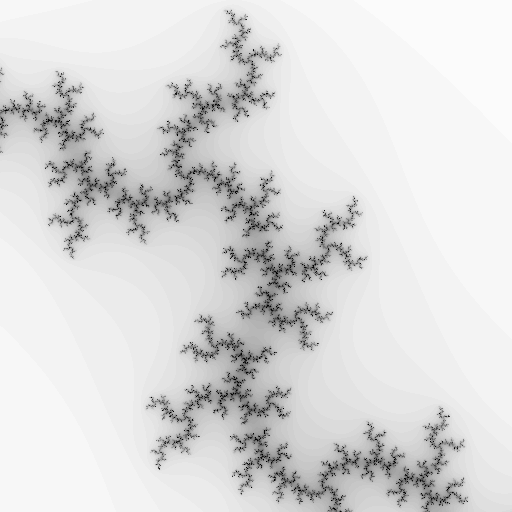

In [34]:
IPython.display.Image(filename='./julia_zoomed.gif')